In [8]:
from lolviz import *

In [17]:
class Node:
  def __init__(self, value):
    self.value = value
    self.edges = [] # outgoing edges
  def add(self, target):
    self.edges.append(target)
  def __repr__(self): return str(self.value)

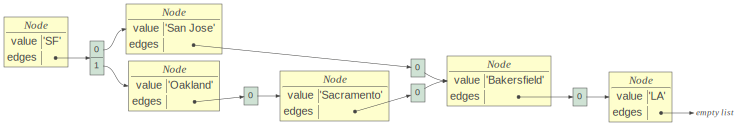

In [18]:
sf = Node("SF")
la = Node("LA")
sac = Node("Sacramento")
oak = Node("Oakland")
baker = Node("Bakersfield")
sj = Node("San Jose")
sf.add(sj)
sj.add(baker)
sf.add(oak)
oak.add(sac)
sac.add(baker)
baker.add(la)

objviz(sf)

# Reachable nodes

We need two sets, one for cycle avoidance and the other to track the nodes we reach. If we used `seen` for both, then `p` would also appear to reach itself, which might not be true.

In [26]:
def reachable(p:Node) -> set:
    reaches = set();
    reachable_(p, reaches, set())
    return reaches

def reachable_(p:Node, reaches:set, seen:set):
    if p in seen: return
    seen.add(p)
    for q in p.edges:
        reaches.add(q)
        reachable_(q, reaches, seen)

In [30]:
reachable(sf)

({Bakersfield, LA, Oakland, Sacramento, San Jose}, {Bakersfield, LA}, {LA})

In [31]:
reachable(sj)

{Bakersfield, LA}

In [32]:
reachable(baker)

{LA}

In [33]:
reachable(la)

set()

# Find path

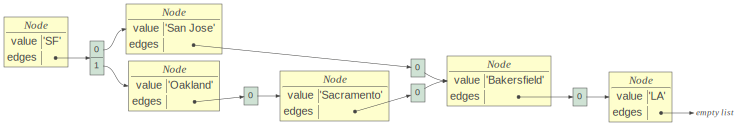

In [56]:
fresno = Node("Fresno")
fresno.add(baker)
objviz(sf)

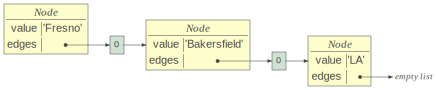

In [57]:
objviz(fresno)

In [91]:
def path(p:Node, q:Node) -> list:
    return path_(p, q, [p], set())

def path_(p:Node, q:Node, path:list, seen:set) -> list:
    if p is q: return path
    if p in seen: return None
    seen.add(p)
    for t in p.edges:
        pa = path_(t, q, path+[t], seen)
        if pa is not None: return pa
    return None

In [92]:
path(sf,la)

[SF, San Jose, Bakersfield, LA]

In [96]:
path(sf,fresno) # no path yields None

In [94]:
path(sf,sf) # node can reach itself by not traversing so path len is 1

[SF]

# Labeled edges

In [97]:
class LNode:
  def __init__(self, value):
    self.value = value
    self.edges = {} # outgoing edges
  def add(self, label, target):
    self.edges[label] = target
  def __repr__(self): return str(self.value)

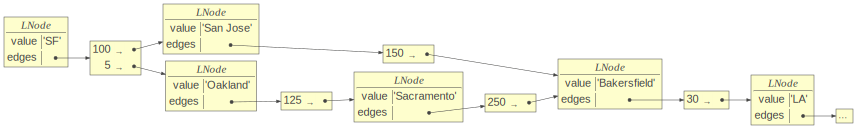

In [118]:
sf = LNode("SF")
la = LNode("LA")
sac = LNode("Sacramento")
oak = LNode("Oakland")
baker = LNode("Bakersfield")
sj = LNode("San Jose")
sf.add(100,sj)
sj.add(150,baker)
sf.add(5,oak)
oak.add(125,sac)
sac.add(250,baker)
baker.add(30,la)

fresno = LNode("Fresno")
fresno.add(60,baker)

objviz(sf)

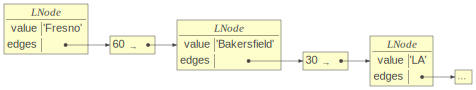

In [119]:
objviz(fresno)

# Breadth-first search

Children first then grandchildren; add to worklist and feed off of that

In [172]:
def BFS(root:Node): 
    visited = {root}
    worklist = [root] 
    while len(worklist)>0: 
        p = worklist.pop(0)
        print(f"Visit {p}")
        # visit all targets of p's edges if not visited
        for q in p.edges:
            if q not in visited:
                print(f"\tAdd {q} to worklist")
                worklist.append(q)
                visited.add(q)

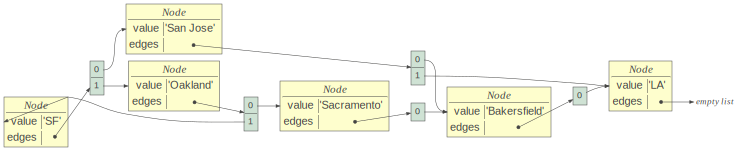

In [181]:
sf = Node("SF")
la = Node("LA")
sac = Node("Sacramento")
oak = Node("Oakland")
baker = Node("Bakersfield")
sj = Node("San Jose")
sf.add(sj)
sj.add(baker)
sf.add(oak)
oak.add(sac)
oak.add(sf)
sac.add(baker)
baker.add(la)
sj.add(la)

objviz(sf)

In [182]:
BFS(sf)

Visit SF
	Add San Jose to worklist
	Add Oakland to worklist
Visit San Jose
	Add Bakersfield to worklist
	Add LA to worklist
Visit Oakland
	Add Sacramento to worklist
Visit Bakersfield
Visit LA
Visit Sacramento


In [183]:
BFS(fresno)

Visit Fresno
	Add Bakersfield to worklist
Visit Bakersfield
	Add LA to worklist
Visit LA


In [184]:
BFS(la)

Visit LA


# Find shortest path (num edges) from p to q

Modify BFS to use work list of paths not nodes

In [185]:
def shortest(root:Node, target:Node): 
    visited = {root}
    worklist = [[root]]
    while len(worklist)>0: 
        path = worklist.pop(0)
        print(f"Process path {path}")
        p = path[-1] # tail of path
        if p is target:
            return path
        for q in p.edges:
            if q not in visited:
                worklist.append(path+[q])
                visited.add(q)

In [186]:
shortest(sf,la)

Process path [SF]
Process path [SF, San Jose]
Process path [SF, Oakland]
Process path [SF, San Jose, Bakersfield]
Process path [SF, San Jose, LA]


[SF, San Jose, LA]

In [187]:
shortest(sf,sj)

Process path [SF]
Process path [SF, San Jose]


[SF, San Jose]

In [188]:
shortest(sj,baker)

Process path [San Jose]
Process path [San Jose, Bakersfield]


[San Jose, Bakersfield]